# Interfacing with Stan
This notebook explains how it is possible to interface with [Stan](https://mc-stan.org/) to make use of their awesome library for log-probability calculations, gradient calculation (via autodiff) and their large zoo of probability distributions.

One thing to be mindful of is that the interface below only allows the log probability to be accessed from Stan objects up to an additive constant.

In this notebook, we use the [Eight Schools example](http://pints.readthedocs.io/en/latest/toy/eight_schools.html) and show how the model can be defined in Stan but called from in Pints.

In [1]:
import pystan

Define Stan model using their syntax.

In [2]:
code="""
data {
  int<lower=0> J;
  real y[J];
  real<lower=0> sigma[J];
}

parameters {
  real mu;
  real<lower=0> tau;
  real theta[J];
}

model {
  mu ~ normal(0, 5);
  tau ~ cauchy(0, 5);
  theta ~ normal(mu, tau);
  y ~ normal(theta, sigma);
}
"""

Then compile Stan model (we also show code below to save the compiled model to avoid having to redo compilation).

In [3]:
import pickle
sm = pystan.StanModel(model_code=code)

# to pickle compiled model
with open('model.pkl', 'wb') as f:
    pickle.dump(sm, f)

# to load pickled compiled model
sm = pickle.load(open('model.pkl', 'rb'))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6e11919b5314121a277ebece94b64d05 NOW.


## Centered model

Import the Eight Schools ("centered" parameterisation) model from Pints: just to provide the data for fitting the Stan model in Pints.

In [4]:
import pints
import pints.toy
import pints.interfaces
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.stats

model = pints.toy.EightSchoolsLogPDF()

Use the data provided with Pints' toy model to run Stan's NUTS for a few iterations (only needed so that we can access the functions bound to a stanfit object, so ignore warnings).

In [5]:
fit = sm.sampling(data=model.data(), iter=10, chains=1, verbose=True, refresh=10)

Run [relativistic HMC](../sampling/relativistic-mcmc.ipynb) sampler using this model. To do so, we first need to provide Pints with boundaries for each parameter, since Pints operates in the constrained space whereas Stan operates in unconstrained space.

In [6]:
# initialise
xs = [np.random.normal(size=10) for chain in range(4)]
# set 1st element of each list to positive number since corresponds to a scale parameter
for x in xs:
    x[1] = np.random.uniform()

# Define boundaries for each parameter
# use a large value that extends much beyond typical range of distribution
max_val = 1000
upper = np.concatenate(([max_val, max_val], np.repeat(max_val, 8)))
lower = np.concatenate(([-max_val, 0], np.repeat(-max_val, 8)))
boundaries = pints.RectangularBoundaries(lower, upper)

# instantiate Pints version of Stan model
stanmodel = pints.interfaces.StanLogPDF(fit, rectangular_boundaries=boundaries)
    
mcmc = pints.MCMCController(stanmodel, len(xs), xs, method=pints.RelativisticMCMC)

# Add stopping criterion
mcmc.set_max_iterations(2000)

# Set up modest logging
mcmc.set_log_to_screen(True)
mcmc.set_log_interval(400)

# # Update step sizes used by individual samplers
for sampler in mcmc.samplers():
    sampler.set_leapfrog_step_size(0.2)

start = time.time()
# Run!
print('Running...')
full_chains = mcmc.run()
print('Done!')
end = time.time()

Running...
Using Relativistic MCMC
Generating 4 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Accept.   Time m:s
0     4      0         0         0         0          0:00.0
1     84     0.333     0         0.333     0          0:00.0
2     164    0.5       0         0.5       0          0:00.0
3     244    0.6       0         0.6       0.2        0:00.1
400   32004  0.868     0         0.771     0.754      0:06.7
800   64004  0.81      0         0.818     0.712      0:13.3
1200  96004  0.765391  0         0.801     0.722      0:19.8
1600  128004  0.727216  0         0.782     0.752      0:26.4
2000  159924  0.725     0         0.793     0.751      0:33.0
Halting: Maximum number of iterations (2000) reached.
Done!


In [7]:
results = pints.MCMCSummary(chains=full_chains, time=(end-start), parameter_names=stanmodel.names())
print(results)

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess    ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  -----  --------------
mu       1.42    2.62    -2.02   -0.35  0.30   3.10   7.70     1.88    31.91  0.97
tau      2.47    2.55    0.07    0.07   1.91   3.63   9.76     1.32    nan    nan
theta.1  3.13    3.57    -1.78   0.76   1.40   6.05   10.65    1.25    22.95  0.70
theta.2  2.27    3.57    -1.69   -1.07  1.09   4.99   10.07    1.39    24.53  0.74
theta.3  1.40    2.91    -3.70   -0.20  0.95   2.36   8.33     1.59    44.39  1.35
theta.4  1.01    3.55    -4.09   -1.78  -0.09  3.31   8.76     1.72    19.10  0.58
theta.5  -0.05   3.94    -9.01   -1.07  -1.02  2.14   8.37     1.54    27.09  0.82
theta.6  -0.01   4.13    -7.86   -2.22  0.38   1.45   9.06     1.51    nan    nan
theta.7  3.71    3.91    -1.49   1.37   1.94   6.36   12.53    1.25    21.91  0.66
theta.8  0.94    3.91    -3.62   -3.05  0.15   3.60   9.05     1.61    

/Volumes/Samsung1.5TB/Github/pints/pints/_diagnostics.py:16: RuntimeWarning: invalid value encountered in true_divide
  x = (x - np.mean(x)) / (np.std(x) * np.sqrt(len(x)))


The wandering chains here illustrate how difficult inference is for this model.

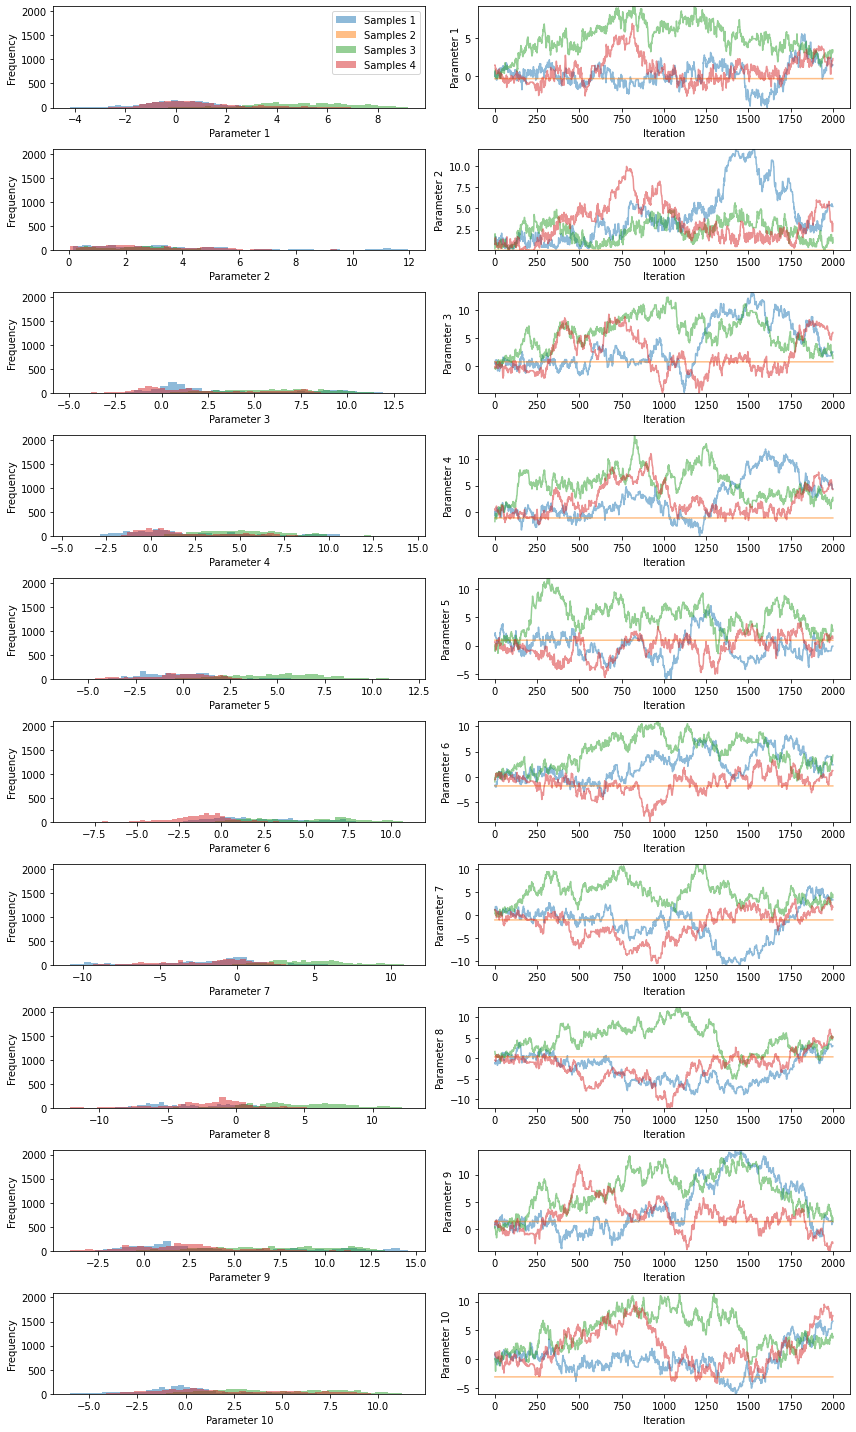

In [8]:
import pints.plot
pints.plot.trace(full_chains)
plt.show()

Just to hammer home the differences between Stan's log probability and Pints': we can compare them for sets of parameter values.

In [9]:
params = np.random.uniform(size=10)

pintsmodel = pints.toy.EightSchoolsLogPDF()

print(str("Stan log prob: " + str(stanmodel(params))))
print(str("Pints log prob: " + str(pintsmodel(params))))

Stan log prob: -1.6344004401840522
Pints log prob: -40.36444825127784


The same goes for sensitivities!

In [10]:
p1, dp1 = stanmodel.evaluateS1(params)
p2, dp2 = pintsmodel.evaluateS1(params)

print(str("Stan d log(prob)/dmu: " + str(dp1[0])))
print(str("Pints d log(prob)/dmu: " + str(dp2[0])))

Stan d log(prob)/dmu: 3.477968267575013
Pints d log(prob)/dmu: -0.02120232767788464


## Non-centered model

To speed things up, we can move to Stan's non-centered parameterisation. (Pints also has a version of this model: ) This model introduces auxillary variables $\tilde{\theta}_j$ which ensure the joint distribution: $p(\mu,\tau, \boldsymbol{\theta})$ remains the same, but is easier to sample from.

In [11]:
code="""
data {
  int<lower=0> J;
  real y[J];
  real<lower=0> sigma[J];
}

parameters {
  real mu;
  real<lower=0> tau;
  real theta_tilde[J];
}

transformed parameters {
  real theta[J];
  for (j in 1:J)
    theta[j] = mu + tau * theta_tilde[j];
}

model {
  mu ~ normal(0, 5);
  tau ~ cauchy(0, 5);
  theta_tilde ~ normal(0, 1);
  y ~ normal(theta, sigma);
}
"""

Compile Stan model and run it for a few iterations to get a stanfit object.

In [12]:
import pickle
sm = pystan.StanModel(model_code=code)

# to pickle compiled model
with open('model_ncp.pkl', 'wb') as f:
    pickle.dump(sm, f)

# to load pickled compiled model
sm = pickle.load(open('model_ncp.pkl', 'rb'))

# Run Stan model for a few iterations
fit = sm.sampling(data=model.data(), iter=10, chains=1, verbose=True, refresh=10)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3f8f9e8bb354ab461436bb51d935571d NOW.


Retry sampling, this time with the non-centered parameterisation.

In [13]:
# initialise
xs = [np.random.normal(size=10) for chain in range(4)]
# set 1st element of each list to positive number since corresponds to a scale parameter
for x in xs:
    x[1] = np.random.uniform()

# Define boundaries for each parameter
# use a large value that extends much beyond typical range of distribution
max_val = 1000
upper = np.concatenate(([max_val, max_val], np.repeat(max_val, 8)))
lower = np.concatenate(([-max_val, 0], np.repeat(-max_val, 8)))
boundaries = pints.RectangularBoundaries(lower, upper)

# instantiate Pints version of Stan model
stanmodel = pints.interfaces.StanLogPDF(fit, rectangular_boundaries=boundaries)

mcmc = pints.MCMCController(stanmodel, len(xs), xs, method=pints.HamiltonianMCMC)

# Add stopping criterion
mcmc.set_max_iterations(2000)

# Set up modest logging
mcmc.set_log_to_screen(True)
mcmc.set_log_interval(200)

# # Update step sizes used by individual samplers
for sampler in mcmc.samplers():
    sampler.set_leapfrog_step_size(0.2)

start = time.time()
# Run!
print('Running...')
full_chains = mcmc.run()
print('Done!')
end = time.time()

Running...
Using Hamiltonian Monte Carlo
Generating 4 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Accept.   Time m:s
0     4      0         0         0         0          0:00.0
1     84     0.333     0         0         0.333      0:00.0
2     164    0.5       0.25      0.25      0.5        0:00.0
3     244    0.6       0.2       0.4       0.6        0:00.0
200   16004  0.921     0.881     0.817     0.847      0:02.8
400   32004  0.856     0.908     0.774     0.697      0:05.6
600   48004  0.847     0.816     0.792     0.646      0:08.4
800   64004  0.87      0.783     0.829     0.645      0:11.2
1000  80004  0.881     0.817     0.813     0.673      0:14.0
1200  96004  0.885     0.817     0.774     0.701      0:16.8
1400  112004  0.885     0.83      0.746077  0.705      0:19.7
1600  128004  0.866     0.84      0.759     0.735      0:22.5
1800  144004  0.85      0.837     0.77303   0.752      0:25.2
2000  159924  0.854073  0.848     0.771     0.768    

Get back original parameter values: $\theta_j = \mu + \tilde{\theta}_j \tau$.

In [14]:
full_chains_transformed = []
for i in range(len(full_chains)):
    mu = full_chains[i][:, 0]
    tau = full_chains[i][:, 1]
    theta_tilde_j = full_chains[i][:, 2:]
    full_chains_transformed.append(
        np.concatenate((np.transpose(np.vstack((mu, tau))),
                        mu[:, np.newaxis] + (theta_tilde_j * tau[:, np.newaxis])),axis=1))

Aaaaahh, that's better...

In [15]:
results = pints.MCMCSummary(chains=full_chains_transformed,
                            time=(end-start), parameter_names=stanmodel.names())
print(results)

param          mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess     ess per sec.
-------------  ------  ------  ------  -----  -----  -----  -------  ------  ------  --------------
mu             5.05    3.18    -1.02   2.68   4.95   7.13   11.41    1.05    42.06   1.51
tau            6.68    3.66    0.82    3.56   6.46   9.64   13.44    1.08    37.80   1.35
theta_tilde.1  9.20    7.33    -3.23   3.90   8.51   13.70  24.78    1.02    132.00  4.72
theta_tilde.2  6.15    6.15    -5.38   2.25   5.66   9.94   19.19    1.00    143.79  5.15
theta_tilde.3  3.40    6.90    -11.85  -0.29  3.43   7.52   17.09    1.00    193.40  6.92
theta_tilde.4  5.62    6.07    -6.46   1.82   5.25   9.49   18.02    1.02    194.71  6.97
theta_tilde.5  2.89    5.48    -8.41   -0.50  2.92   6.41   13.59    1.00    333.60  11.94
theta_tilde.6  4.09    6.15    -8.47   0.28   3.97   7.77   16.84    1.02    261.47  9.36
theta_tilde.7  8.61    6.37    -1.85   3.97   8.00   12.45  23.43    1.04    139.

...much more efficient sampling!

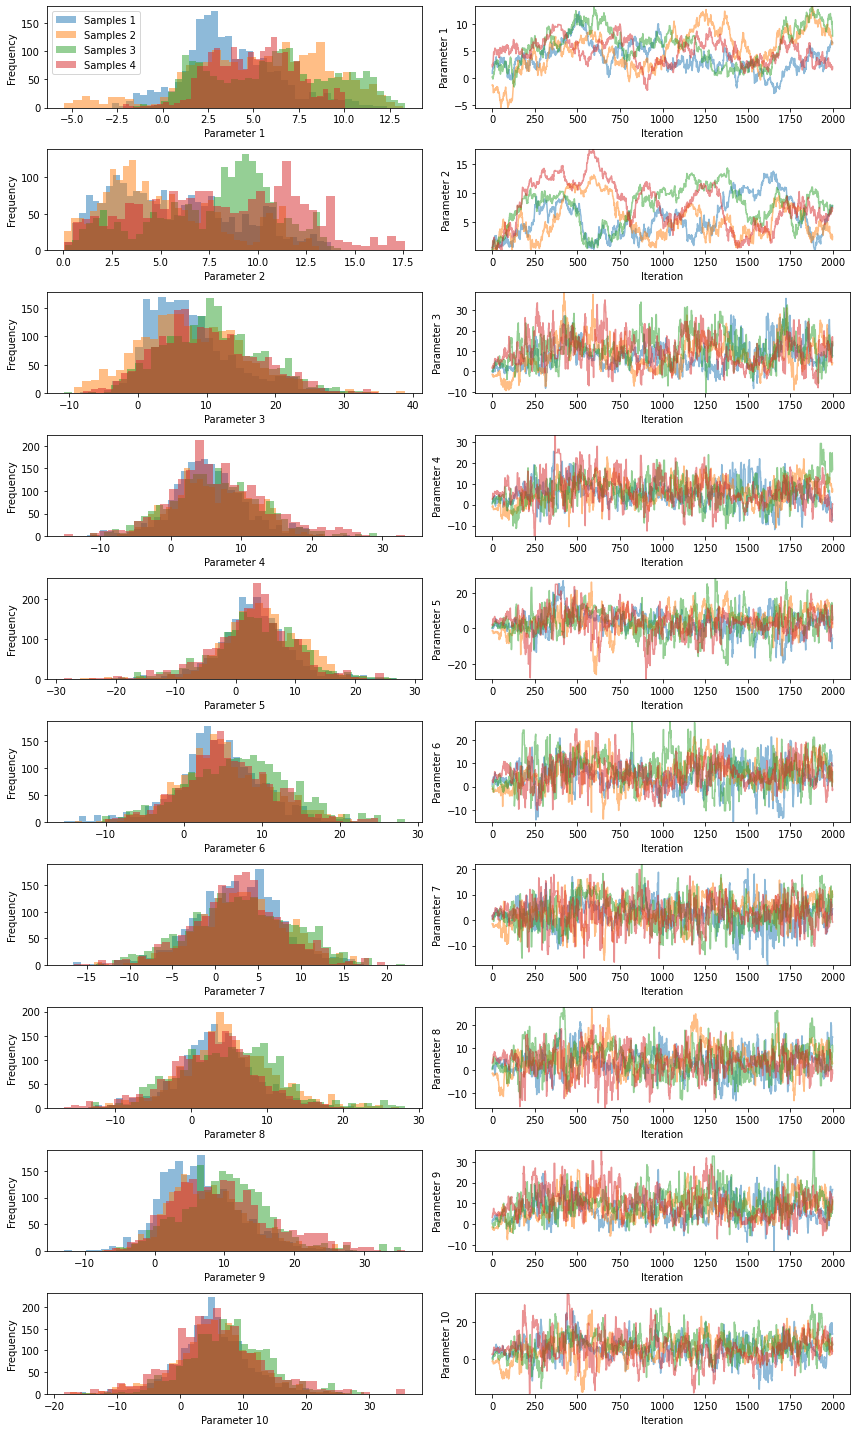

In [16]:
import pints.plot
pints.plot.trace(full_chains_transformed)
plt.show()